<a href="https://colab.research.google.com/github/Rafiur/User_Suggestion_Test/blob/main/User_Suggestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from numpy import nan as NA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cupid = pd.read_csv('/content/drive/MyDrive/user_suggestion/okcupid_profiles.csv')

profiles = cupid.iloc[:,0:21].copy()

In [4]:
print(u'- Number of rows: {}'.format(profiles.shape[0]))
print(u'- Number of columns: {}'.format(profiles.shape[1]))
print(u'- Name of columns : {}'.format(list(profiles.columns)))
print(u'- Dataset shape:{}'.format(profiles.shape))

- Number of rows: 59946
- Number of columns: 21
- Name of columns : ['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'height', 'income', 'job', 'last_online', 'location', 'offspring', 'pets', 'religion', 'sign', 'smokes', 'speaks']
- Dataset shape:(59946, 21)


In [5]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   status       59946 non-null  object 
 2   sex          59946 non-null  object 
 3   orientation  59946 non-null  object 
 4   body_type    54650 non-null  object 
 5   diet         35551 non-null  object 
 6   drinks       56961 non-null  object 
 7   drugs        45866 non-null  object 
 8   education    53318 non-null  object 
 9   ethnicity    54266 non-null  object 
 10  height       59943 non-null  float64
 11  income       59946 non-null  int64  
 12  job          51748 non-null  object 
 13  last_online  59946 non-null  object 
 14  location     59946 non-null  object 
 15  offspring    24385 non-null  object 
 16  pets         40025 non-null  object 
 17  religion     39720 non-null  object 
 18  sign         48890 non-null  object 
 19  smok

In [6]:
profiles.head()


,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (..."
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no,"english, french, c++"
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,20000,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no,"english, german (poorly)"
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,likes dogs and likes cats,NaN,aquarius,no,english


In [7]:
profiles.loc[profiles['income'] == -1, 'income'] = np.nan

In [8]:
print("Null values: \n",profiles.isnull().sum())

Null values: 
 age                0
status             0
sex                0
orientation        0
body_type       5296
diet           24395
drinks          2985
drugs          14080
education       6628
ethnicity       5680
height             3
income         48442
job             8198
last_online        0
location           0
offspring      35561
pets           19921
religion       20226
sign           11056
smokes          5512
speaks            50
dtype: int64


In [9]:
total_count = profiles.isna().count()

count_na = profiles.isna().sum().sort_values(ascending = False)
pct_na =(profiles.isna().sum()/total_count).sort_values(ascending = False)
pd.options.display.float_format = '{:.1%}'.format
missing_data = pd.concat([count_na, pct_na], axis=1, keys=['Count', 'Percent'])

missing_data[missing_data['Percent']>=0.01]

,Count,Percent
income,48442,80.8%
offspring,35561,59.3%
diet,24395,40.7%
religion,20226,33.7%
pets,19921,33.2%
drugs,14080,23.5%
sign,11056,18.4%
job,8198,13.7%
education,6628,11.1%
ethnicity,5680,9.5%


In [10]:
profiles.drop(['income', 'offspring'], axis=1, inplace=True)

In [11]:
profiles['height'] = profiles['height'].apply(lambda x: round(x * 2.54, 0))


In [12]:
f_mean = round(profiles.loc[profiles['sex']=='f','height'].mean(),0) # 165
m_mean = round(profiles.loc[profiles['sex']=='m','height'].mean(),0) # 179

In [13]:
profiles.loc[(profiles['height'].isna()) & (profiles['sex']=='f'), 'height'] = f_mean
profiles.loc[(profiles['height'].isna()) & (profiles['sex']=='m'), 'height'] = m_mean

In [14]:
profiles.loc[(profiles['height'] <= 100) & (profiles['sex']=='f'), 'height'] = f_mean
profiles.loc[(profiles['height'] <= 100) & (profiles['sex']=='m'), 'height'] = m_mean

In [15]:
profiles.drop(['speaks','location','last_online','status'], axis=1, inplace=True)

In [16]:
encoded_profiles = profiles.copy()

columns_to_encode = ['sex', 'orientation', 'body_type', 
                     'diet', 'drinks', 'drugs', 'education', 'ethnicity', 
                     'job', 'pets', 'religion', 'sign', 'smokes']

for column in columns_to_encode:
    encoded_cols = pd.get_dummies(profiles[column], prefix=column, drop_first=True)
    encoded_profiles = pd.concat([encoded_profiles, encoded_cols], axis=1)
    encoded_profiles.drop(column, axis=1, inplace=True)

encoded_profiles

,age,height,sex_m,orientation_gay,orientation_straight,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,...,sign_taurus and it&rsquo;s fun to think about,sign_taurus but it doesn&rsquo;t matter,sign_virgo,sign_virgo and it matters a lot,sign_virgo and it&rsquo;s fun to think about,sign_virgo but it doesn&rsquo;t matter,smokes_sometimes,smokes_trying to quit,smokes_when drinking,smokes_yes
0,22,19000.0%,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,35,17800.0%,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,17300.0%,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,18000.0%,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,29,16800.0%,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,15700.0%,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59942,24,18300.0%,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
59943,42,18000.0%,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59944,27,18500.0%,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
col_to_scale = ['age', 'height']
X = encoded_profiles[col_to_scale]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
encoded_profiles[col_to_scale] = X_scaled

In [18]:
encoded_profiles.drop(['sex_m'],axis=1,inplace=True)

In [19]:
pca = PCA(n_components=46) 
X_pca = pca.fit_transform(encoded_profiles)


print(pca.explained_variance_ratio_.sum())

0.6899033223117382


In [20]:
num_clusters=list(np.arange(1, 30))

inertias = []

for k in num_clusters:
  model = KMeans(n_clusters = k, n_init='auto')
  model.fit(X_pca)
  inertias.append(model.inertia_)

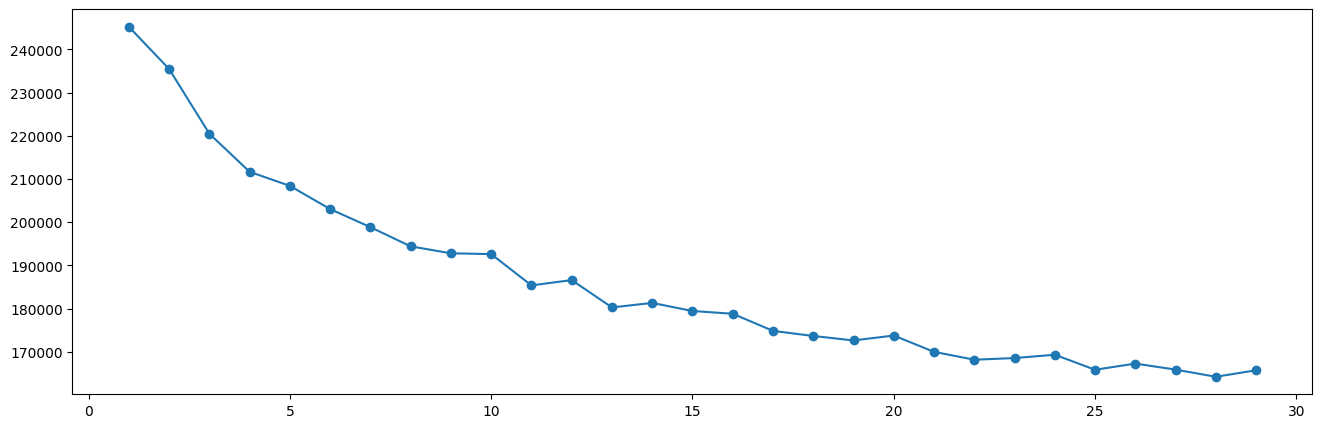

In [21]:
plt.figure(figsize=(16, 5))
plt.plot(num_clusters, inertias, '-o')
plt.show()

In [22]:
k = 10
model = KMeans(n_clusters = k, n_init='auto')
model.fit(X_pca)

profiles['membership'] = model.labels_
profiles.membership.value_counts()

9    8818
1    8569
4    7884
5    5618
3    5573
0    5454
8    5376
7    5068
6    3848
2    3738
Name: membership, dtype: int64

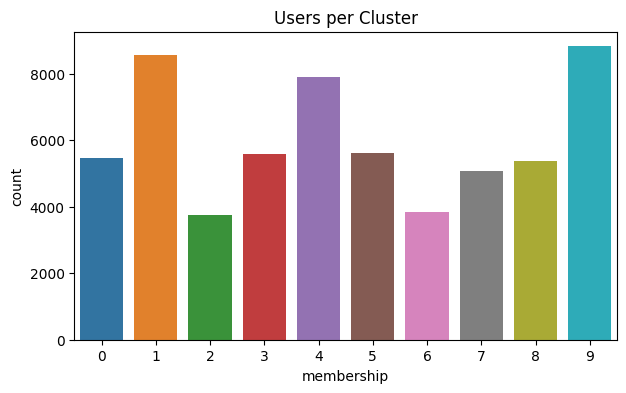

In [23]:
plt.figure(figsize=(7, 4))
sns.countplot(data=profiles, x='membership')
plt.title('Users per Cluster')
plt.show()

In [24]:
profiles['height'] = profiles['height'].astype('int')
profiles.loc[14113:14113,:]

,age,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,job,pets,religion,sign,smokes,membership
14113,18,m,gay,thin,mostly anything,socially,never,working on college/university,middle eastern,168,student,has dogs,atheism and somewhat serious about it,sagittarius and it&rsquo;s fun to think about,no,3


In [25]:
users = profiles.loc[(profiles.sex == 'm') & 
                     (profiles.membership == profiles.at[14113, 'membership']) & 
                     (profiles.orientation == 'gay')].index
print(f'And so we have found {len(users)} male users in the same cluster.\n ')

And so we have found 3985 male users in the same cluster.
 


In [26]:
def distance(row, user):
    result = 0
    for i, v in enumerate(row):
        result += (v - user[i])**2
    return result ** 0.5;

In [27]:
df = pd.DataFrame(X_pca)
user = df.loc[14113]
distances = df.loc[users].apply(distance, axis = 1, args=(user,) ).sort_values();

In [28]:
profiles['height'] = profiles['height'].astype('int')
profiles.loc[distances.index, :].head(10)

,age,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,job,pets,religion,sign,smokes,membership
14113,18,m,gay,thin,mostly anything,socially,never,working on college/university,middle eastern,168,student,has dogs,atheism and somewhat serious about it,sagittarius and it&rsquo;s fun to think about,no,3
10737,22,m,gay,NaN,mostly anything,socially,never,working on college/university,asian,185,NaN,has dogs,catholicism,sagittarius,no,3
42508,21,m,gay,fit,mostly anything,socially,never,working on college/university,asian,170,student,has dogs,buddhism but not too serious about it,capricorn and it&rsquo;s fun to think about,no,3
23189,28,m,gay,thin,NaN,socially,NaN,working on college/university,"hispanic / latin, white",178,student,NaN,atheism and somewhat serious about it,aquarius but it doesn&rsquo;t matter,no,3
12680,20,m,gay,thin,mostly anything,socially,never,working on college/university,"asian, other",185,student,has dogs and likes cats,NaN,aries and it&rsquo;s fun to think about,no,3
3064,19,m,gay,skinny,mostly anything,socially,never,working on college/university,"native american, white, other",188,student,NaN,NaN,capricorn and it&rsquo;s fun to think about,no,3
2236,20,m,gay,used up,mostly anything,socially,never,working on college/university,hispanic / latin,183,student,NaN,NaN,cancer but it doesn&rsquo;t matter,no,3
14941,23,m,gay,thin,NaN,socially,never,working on college/university,"hispanic / latin, other",173,student,has dogs and likes cats,agnosticism,leo and it&rsquo;s fun to think about,no,3
27420,24,m,gay,thin,mostly anything,socially,never,NaN,"asian, pacific islander, white",170,artistic / musical / writer,NaN,NaN,cancer and it&rsquo;s fun to think about,no,3
19055,19,m,gay,a little extra,mostly anything,socially,never,high school,black,178,student,has dogs,atheism and laughing about it,taurus and it&rsquo;s fun to think about,no,3


In [29]:
profiles.loc[2326:2326,:]

,age,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,job,pets,religion,sign,smokes,membership
2326,29,f,straight,thin,anything,socially,NaN,working on college/university,white,163,medicine / health,likes dogs and likes cats,NaN,aries and it&rsquo;s fun to think about,no,1


In [30]:
users = profiles.loc[(profiles.sex == 'm') & 
                     (profiles.membership == profiles.at[2326, 'membership']) & 
                     (profiles.orientation == 'straight')].index
print(f'And so we have found {len(users)} male users in the same cluster.\n ')

And so we have found 4291 male users in the same cluster.
 


In [31]:
df = pd.DataFrame(X_pca)
user = df.loc[2326]
distances = df.loc[users].apply(distance, axis = 1, args=(user,) ).sort_values();

In [32]:
profiles['height'] = profiles['height'].astype('int')
profiles.loc[distances.index, :].head(10)

,age,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,job,pets,religion,sign,smokes,membership
20520,58,m,straight,thin,NaN,socially,never,graduated from ph.d program,white,188,medicine / health,likes dogs and likes cats,NaN,scorpio and it&rsquo;s fun to think about,no,1
14506,28,m,straight,a little extra,NaN,socially,never,working on college/university,white,180,political / government,likes dogs and likes cats,NaN,taurus but it doesn&rsquo;t matter,no,1
15012,40,m,straight,NaN,NaN,socially,never,working on college/university,white,185,artistic / musical / writer,likes dogs and likes cats,catholicism and laughing about it,capricorn and it&rsquo;s fun to think about,no,1
49321,26,m,straight,NaN,NaN,socially,never,working on college/university,white,193,NaN,likes dogs and likes cats,agnosticism and somewhat serious about it,leo but it doesn&rsquo;t matter,no,1
19591,25,m,straight,NaN,NaN,socially,never,working on college/university,white,188,medicine / health,NaN,NaN,NaN,no,1
31928,49,m,straight,thin,NaN,socially,NaN,ph.d program,white,183,NaN,likes dogs and likes cats,NaN,NaN,NaN,1
13750,38,m,straight,thin,anything,socially,NaN,NaN,white,178,NaN,likes dogs and likes cats,atheism but not too serious about it,libra but it doesn&rsquo;t matter,NaN,1
23419,20,m,straight,thin,NaN,socially,never,working on college/university,white,188,student,likes dogs and likes cats,NaN,leo but it doesn&rsquo;t matter,no,1
5769,60,m,straight,thin,NaN,socially,never,working on space camp,white,180,rather not say,likes dogs and likes cats,NaN,aries but it doesn&rsquo;t matter,no,1
47842,32,m,straight,thin,mostly anything,socially,sometimes,working on college/university,white,196,medicine / health,likes dogs and likes cats,agnosticism,pisces and it&rsquo;s fun to think about,no,1


For n_clusters = 10, the average silhouette score is: 0.05663187798971603


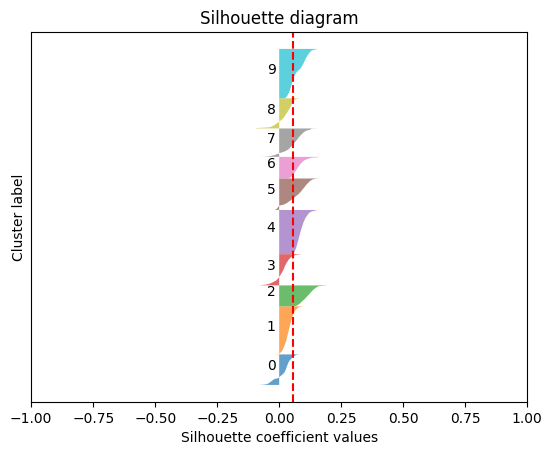

In [33]:
from sklearn.metrics import silhouette_samples, silhouette_score
n_clusters = 10

silhouette_avg = silhouette_score(X_pca, model.labels_)
print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(X_pca, model.labels_)

fig, ax = plt.subplots()
y_lower = 10
for i in range(n_clusters):
    
    cluster_i_values = sample_silhouette_values[model.labels_ == i]
    cluster_i_values.sort()
 
    cluster_size = cluster_i_values.shape[0]
    y_upper = y_lower + cluster_size

    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_i_values, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

ax.set_title("Silhouette diagram")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")


ax.set_yticks([])
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_xlim([-1, 1])

plt.show()